# 模型评估方法

## 数据集读取
- Mnist数据是图像数据，：(28,28,1)的灰度图

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(name='mnist_784', version=1)

/Users/wangjingran/anaconda3/envs/PTEN/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
X = mnist["data"]
y = mnist["target"]
print(X.shape) # 70000个样本数量    28 * 28 = 784个像素点
print(y.shape) # 标签，第一个就是1，第二个就是2...

(70000, 784)
(70000,)


- 训练集和测试集的划分

In [3]:
# 选取前60000个作为训练集，后面的属于测试集
X_train = X[:60000]
X_test = X[60000:]
y_train = y[:60000]
y_test = y[60000:]

- 洗牌操作

In [8]:
import pandas as pd
import numpy as np

# 使用np.random.permutation函数生成随机的索引
shuffle_index = np.random.permutation(X_train.index)

# 根据随机索引对特征和目标进行重排列
X_train = X_train.iloc[shuffle_index]
y_train = y_train.iloc[shuffle_index]


## 交叉验证
- 将训练集再次切分生成训练集和测试集
- 交叉选择训练集和测试集——直到进行所有的排列组合

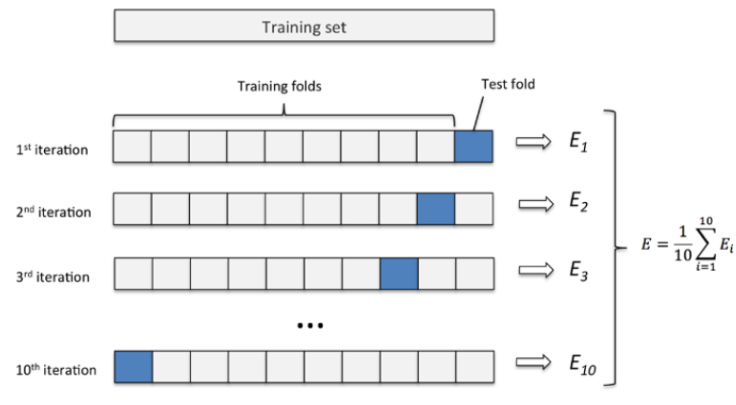

In [ ]:
# 简单判断
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')
y_train_5[:15]

In [14]:
# 模型训练
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter= 5, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

/Users/wangjingran/anaconda3/envs/PTEN/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=5, random_state=42)

In [26]:
# 预测
print(sgd_clf.predict(X.loc[[35000]]))
print(y.loc[35000])
print(sgd_clf.predict(X.loc[[463]]))
print(y.loc[463])

[False]
1
[ True]
5


In [27]:
# 使用交叉验证
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy") # cv = 3切分位3份

/Users/wangjingran/anaconda3/envs/PTEN/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/wangjingran/anaconda3/envs/PTEN/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/wangjingran/anaconda3/envs/PTEN/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.9669 , 0.9662 , 0.96115])

## 混淆矩阵

- TP(Ture positive) —— 正类判定为正类
- FP(NonRelevant) —— 负类判定为正类
- FN(false negative) —— 正类判断为负类
- TN(true negatives) —— 负类判断为负类

In [32]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

/Users/wangjingran/anaconda3/envs/PTEN/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/wangjingran/anaconda3/envs/PTEN/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/wangjingran/anaconda3/envs/PTEN/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [35]:
# 生成混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53921,   658],
       [ 1457,  3964]])

In [38]:
# 精确值和recall值
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
# F1 score调和平均值
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.8576373864128083
0.7312304002951485
0.7894055561087325


## 阈值对结果的影响
- 阈值越低，recall值越大（正值都被找出来），precision变低

In [42]:
# 得分值
y_scores = sgd_clf.decision_function(X.loc[[463]])
print(y_scores)
# 设置阈值
t = 100000 # 当得分大于10000时才判断为正确
y_pred= (y_scores > 0)
print(y_pred)


[100280.48453543]


array([ True])

- Scikit_learn不允许直接设置阈值，但是可以获得决策分数，调用其desicion_function()方法，而不是调用分类器的predict()方法

In [48]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")
from sklearn.metrics import precision_recall_curve
precision, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print(precision.shape)
print(recalls.shape)
print(thresholds.shape)

/Users/wangjingran/anaconda3/envs/PTEN/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/wangjingran/anaconda3/envs/PTEN/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


(60000,)
(60000,)
(59999,)


/Users/wangjingran/anaconda3/envs/PTEN/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


- 精度值和recall值随阈值的变化曲线变化曲线

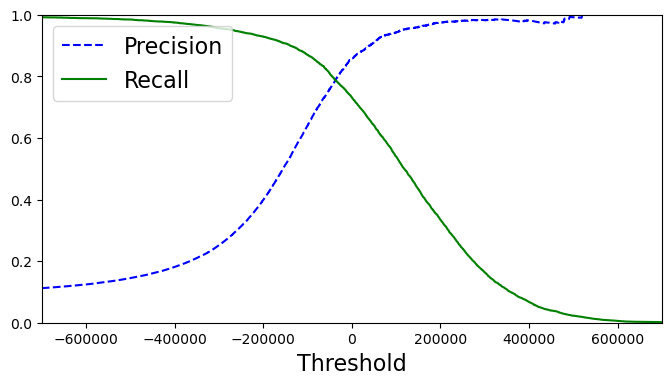

In [53]:
import matplotlib.pyplot as plt
# 显示随着阈值的变化——precision和recall值的变化
def plot_precision_recall(precision, recalls, thresholds):
    plt.plot(thresholds,
             precision[:-1],
             "b--",
             label = "Precision")
    plt.plot(thresholds,
             recalls[:-1],
             "g-",
             label = "Recall")
    plt.xlabel("Threshold", fontsize = 16)
    plt.legend(loc = "upper left", fontsize = 16)
    plt.ylim([0, 1])
plt.figure(figsize=(8, 4))
plot_precision_recall(precision, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

- precision随recall的变化曲线

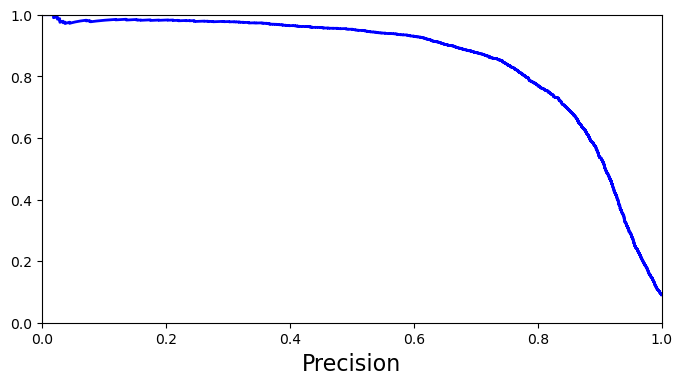

In [54]:
def plot_precision_recall_(precision, recalls):
    plt.plot(recalls,
             precision,
             "b-",
             linewidth = 2)
    plt.xlabel("Recall", fontsize = 16)
    plt.xlabel("Precision", fontsize = 16)
    plt.axis([0,1,0,1])
plt.figure(figsize=(8, 4))
plot_precision_recall_(precision, recalls)
plt.show()

## ROC曲线
- 绘制True positive rate和false positive rate
    - TPR   $TPR = \frac{TP}{TP + FN}$ 
    - FPR   $FPR = \frac{FP}{FP + TN}$
    - **虚线表示随机分类器的ROC曲线**
    - **一个好的分类器尽量朝向左上角远离该线**

In [55]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

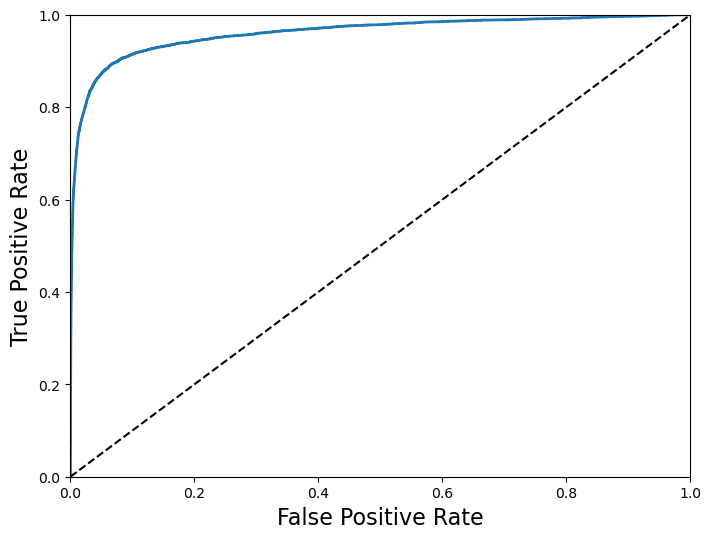

In [56]:
import matplotlib.pyplot as plt
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize = 16)
    plt.ylabel('True Positive Rate', fontsize = 16)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

- 比较分类器的方法：曲线下的面积（AUC），完美的分类器AUC为1，纯随机分类器AUC为0.5

In [57]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9607813337083866